# Fine-Tuning LLaMA 2 Models with a single GPU and OVHcloud

**In this OVHcloud tutorial, we will walk you through the process of fine-tuning LLaMA 2 models, providing step-by-step instructions.**

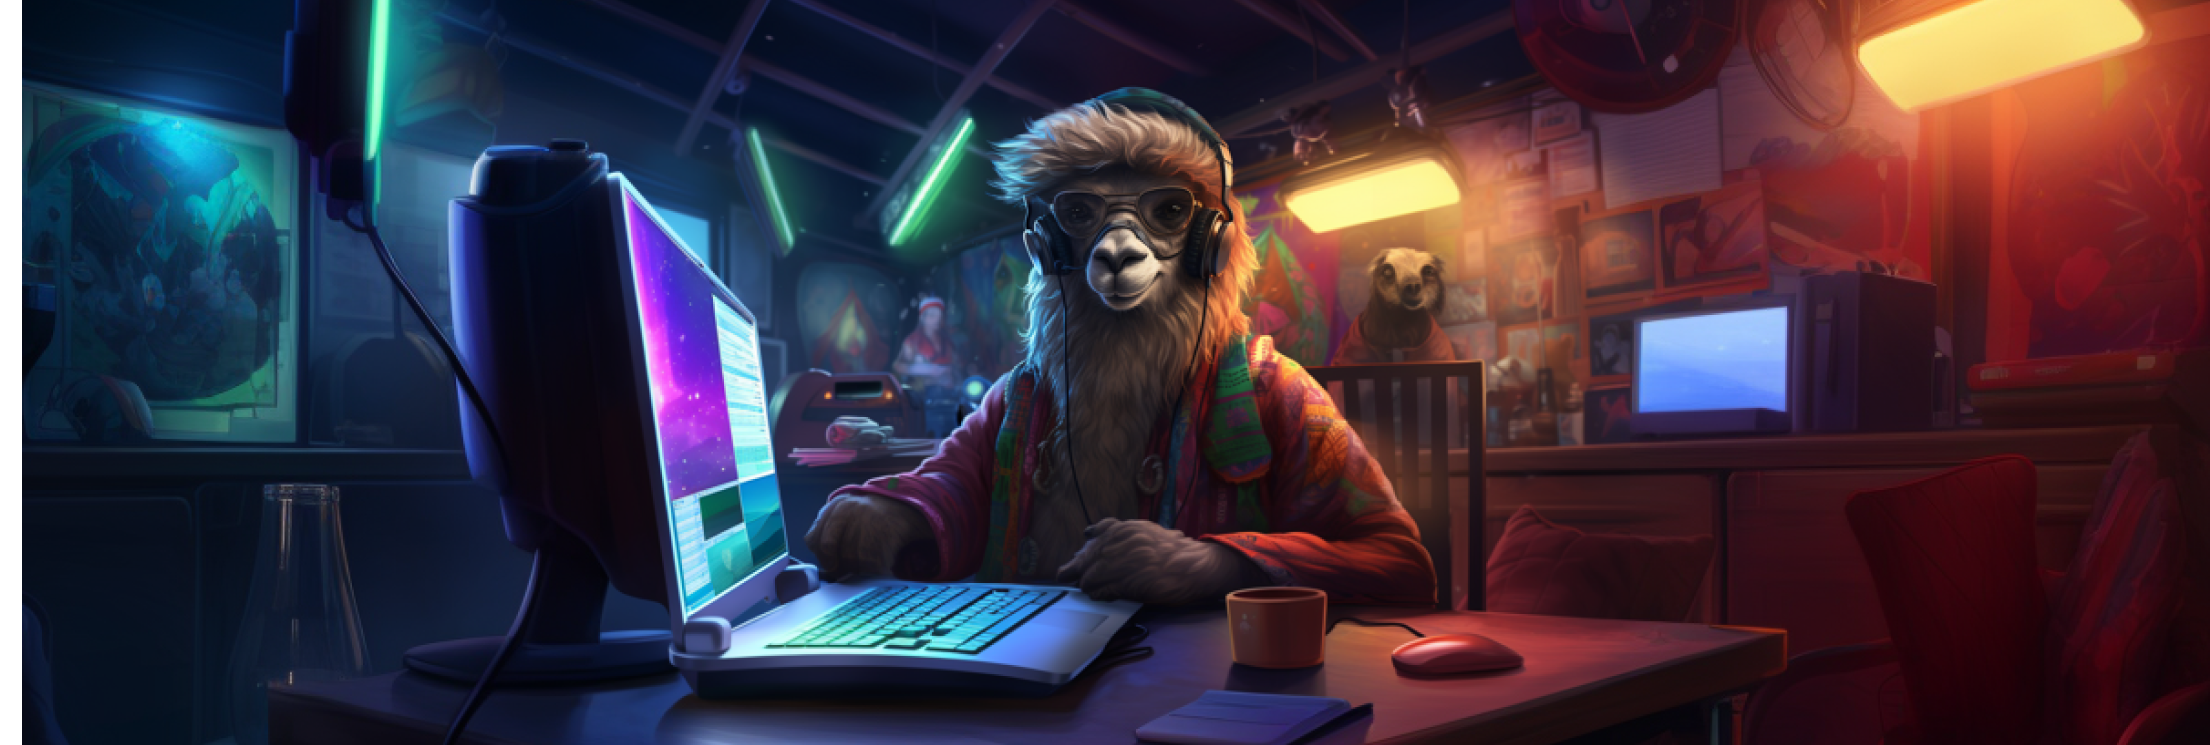

### Introduction

On July 18, 2023, [Meta](https://about.meta.com/) released [LLaMA 2](https://ai.meta.com/llama/), the latest version of their Large Language Model (LLM).

Trained between January 2023 and July 2023 on 2 trillion tokens, these new models outperforms other LLMs on many benchmarks, including reasoning, coding, proficiency, and knowledge tests. This release comes in different flavors, with parameter sizes of 7B, 13B, and a mind-blowing 70B. Models are intended for free for both commercial and research use in English.

To suit every text generation needed and fine-tune these models, we will use [QLoRA (Efficient Finetuning of Quantized LLMs)](https://arxiv.org/abs/2305.14314), a highly efficient fine-tuning technique that involves quantizing a pretrained LLM to just 4 bits and adding small "Low-Rank Adapters". This unique approach allows for fine-tuning LLMs using just a single GPU! This technique is supported by the [PEFT library](https://huggingface.co/docs/peft/). 

### Requirements

To successfully fine-tune LLaMA 2 models, you will need the following:

- **Set up your Python environment** by installing the `requirements.txt` file
- **Llama 2 Model**. To obtain the Llama 2 model, you will need to:
    - Fill Meta's form to [request access to the next version of Llama](https://ai.meta.com/resources/models-and-libraries/llama-downloads/). Indeed, the use of Llama 2 is governed by the Meta license, that you must accept in order to download the model weights and tokenizer.
    - Have a [Hugging Face](https://huggingface.co/) account (with the same email address you entered in Meta's form).
    - Have a [Hugging Face token](https://huggingface.co/settings/tokens).
    - Visit the page of one of the LLaMA 2 available models (version [7B](https://huggingface.co/meta-llama/Llama-2-7b-hf), [13B](https://huggingface.co/meta-llama/Llama-2-13b-hf) or [70B](https://huggingface.co/meta-llama/Llama-2-70b-hf)), and accept Hugging Face's license terms and acceptable use policy. 
    > Once you have accepted this, you will get the following message: *Your request to access this repo has been successfully submitted, and is pending a review from the repo's authors*, which a few hours later should change to: *You have been granted access to this model*. 
    - Log in to the Hugging Face model Hub from your notebook's terminal. To do this, just click the `+` button and open a terminal. You can also perform this by clicking `File` > `New` > `Terminal`. Then, use the `huggingface-cli login` command, and enter your token. You will not need to add your token as git credential.
<br><br>
- **Powerful Computing Resources**: Fine-tuning the Llama 2 model requires substantial computational power. Ensure you are running code on GPU(s).

In [ ]:
# Set up Python environment 
!pip install -r requirements.txt

In [2]:
# Import libraries 
import argparse
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset

# Reproducibility
seed = 42
set_seed(seed)

### Download LLaMA 2 model
As mentioned before, LLaMA 2 models come in different flavors which are 7B, 13B, and 70B. Your choice can be influenced by your computational resources. Indeed, larger models require more resources, memory, processing power, and training time.

To download the model you have been granted access to, **make sure you are logged in to the Hugging Face model hub**. As mentioned in the requirements step, you need to use the `huggingface-cli login` command.

The following function will help us to download the model and its tokenizer. It requires a bitsandbytes configuration that we will define later.

In [3]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

### Download a Dataset

There are many datasets that can help you fine-tune your model. You can even use your own dataset!

In this tutorial, we are going to download and use the [Databricks Dolly 15k dataset](https://huggingface.co/datasets/databricks/databricks-dolly-15k), which contains 15,000 prompt/response pairs. It was crafted by over 5,000 [Databricks](https://www.databricks.com/) employees during March and April of 2023.

This dataset is designed specifically for fine-tuning large language models. Released under the [CC BY-SA 3.0 license](https://creativecommons.org/licenses/by-sa/3.0/), it can be used, modified, and extended by any individual or company, even for commercial applications. So it's a perfect fit for our use case! 

However, like most datasets, this one has its limitations. Indeed, pay attention to the following points:
- It consists of content collected from the public internet, which means it may contain objectionable, incorrect or biased content and typo errors, which could influence the behavior of models fine-tuned using this dataset.
- Since the dataset has been created for Databricks by their own employees, it's worth noting that the dataset reflects the interests and semantic choices of Databricks employees, which may not be representative of the global population at large.
- We only have access to the `train` split of the dataset, which is its largest subset.

In [4]:
# Load the databricks dataset from Hugging Face
from datasets import load_dataset

dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /workspace/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-7427aa6e57c34282/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


### Explore dataset

Once the dataset is downloaded, we can take a look at it to understand what it contains: 

In [5]:
print(f'Number of prompts: {len(dataset)}')
print(f'Column names are: {dataset.column_names}')

Number of prompts: 15011
Column names are: ['instruction', 'context', 'response', 'category']


As we can see, it is composed of 4 fields named `instruction`, `context`, `response`, `category`. Let's take a look at 3 samples to better understand what we are talking about:

In [6]:
import random
import pandas as pd

# Generate random indices
nb_samples = 3
random_indices = random.sample(range(len(dataset)), nb_samples)
samples = []

for idx in random_indices:
    sample = dataset[idx]
    
    sample_data = {
        'instruction': sample['instruction'],
        'context': sample['context'],
        'response': sample['response'],
        'category': sample['category']
    }
    samples.append(sample_data)

# Create a DataFrame and display it
df = pd.DataFrame(samples)      
display(df)

,instruction,context,response,category
0,What athlete created the 'beast quake' for the...,,Marshan Lynch,open_qa
1,Who wrote Democracy in America?,,Alexis de Tocqueville wrote Democracy in America,open_qa
2,"What links Brazil, Uruguay, Mozambique and Angola",,Colonies of Portugal,open_qa


As we can see, each sample is a dictionary that contains:
- **An instruction**: What could be entered by the user, such as a question
- **A context**: Help to interpret the sample
- **A response**: Answer to the instruction
- **A category**: Classify the sample between Open Q&A, Closed Q&A, Extract information from Wikipedia, Summarize information from Wikipedia, Brainstorming, Classification, Creative writing

In [7]:
print(sample)

{'instruction': 'What links Brazil, Uruguay, Mozambique and Angola', 'context': '', 'response': 'Colonies of Portugal', 'category': 'open_qa'}


If you look at several samples, you will see that most do not contain any `context`. But don't worry, it doesn't matter. What we need to do now is to pre-process our data.

### Pre-processing dataset

Instruction fine-tuning is a common technique used to fine-tune a base LLM for a specific downstream use-case.

It will help us to format our prompts.

In [8]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction', 'context', 'response')
    Then concatenate them using two newline characters 
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruction:"
    INPUT_KEY = "Input:"
    RESPONSE_KEY = "### Response:"
    END_KEY = "### End"
    
    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{sample['instruction']}"
    input_context = f"{INPUT_KEY}\n{sample['context']}" if sample["context"] else None
    response = f"{RESPONSE_KEY}\n{sample['response']}"
    end = f"{END_KEY}"
    
    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    
    sample["text"] = formatted_prompt

    return sample


print(create_prompt_formats(sample)["text"])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What links Brazil, Uruguay, Mozambique and Angola

### Response:
Colonies of Portugal

### End


As we can see, each part is now delimited by hashtags that describe the prompt.

Now, we will use our model tokenizer to process these prompts into tokenized ones. The goal is to create input sequences of uniform length (which are suitable for fine-tuning the language model because it maximizes efficiency and minimize computational overhead), that must not exceed the model's maximum token limit.

In [9]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )


# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int, seed, dataset: str):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """
    
    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)
    
    # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=["instruction", "context", "response", "text", "category"],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)
    
    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

With these functions, our dataset will be ready for fine-tuning ! 

### Create bnb config 

This will allow us to load our LLM in 4 bits. This way, we can divide the used memory by 4 and import the model on smaller devices. We choose to apply bfloat16 compute data type and nested quantization for memory-saving purposes.

In [10]:
def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

To leverage the LoRa method, we need to wrap the model as a PeftModel.

To do this, we need to implement a [LoRa configuration](https://huggingface.co/docs/peft/conceptual_guides/lora):

In [11]:
def create_peft_config(modules):
    """
    Create Parameter-Efficient Fine-Tuning config for your model
    :param modules: Names of the modules to apply Lora to
    """
    config = LoraConfig(
        r=16,  # dimension of the updated matrices
        lora_alpha=64,  # parameter for scaling
        target_modules=modules,
        lora_dropout=0.1,  # dropout probability for layers
        bias="none",
        task_type="CAUSAL_LM",
    )

    return config

Previous function needs the target modules to update the necessary matrices. The following function will get them for our model:

In [12]:
# SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

Once everything is set up and the base model is prepared, we can use the print_trainable_parameters() helper function to see how many trainable parameters are in the model. We expect the lora_model to have fewer trainable parameters compared to the original one, since we want to perform fine-tuning.

In [13]:
def print_trainable_parameters(model, use_4bit=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params
    if use_4bit:
        trainable_params /= 2
    print(
        f"all params: {all_param:,d} || trainable params: {trainable_params:,d} || trainable%: {100 * trainable_params / all_param}"
    )

### Training

Now that everything is ready, we can pre-process our dataset and load our model using the set configurations.

Then, we can run our fine-tuning process.

In [15]:
# Load model from HF with user's token and with bitsandbytes config
model_name = "meta-llama/Llama-2-7b-hf" 
bnb_config = create_bnb_config()
model, tokenizer = load_model(model_name, bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/workspace/.miniconda3/lib/python3.9/site-packages/transformers/models/auto/tokenization_auto.py:628: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [16]:
## Preprocess dataset
max_length = get_max_length(model)
dataset = preprocess_dataset(tokenizer, max_length, seed, dataset)

Found max lenth: 4096
Preprocessing dataset...


Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15011 [00:00<?, ? examples/s]

In [17]:
def train(model, tokenizer, dataset, output_dir):
    # Apply preprocessing to the model to prepare it by
    # 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
    model.gradient_checkpointing_enable()

    # 2 - Using the prepare_model_for_kbit_training method from PEFT
    model = prepare_model_for_kbit_training(model)

    # Get lora module names
    modules = find_all_linear_names(model)

    # Create PEFT config for these modules and wrap the model to PEFT
    peft_config = create_peft_config(modules)
    model = get_peft_model(model, peft_config)
    
    # Print information about the percentage of trainable parameters
    print_trainable_parameters(model)
    
    # Training parameters
    trainer = Trainer(
        model=model,
        train_dataset=dataset,
        args=TrainingArguments(
            per_device_train_batch_size=1,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            max_steps=15,
            learning_rate=2e-4,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            optim="paged_adamw_8bit",
        ),
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
    )
    
    model.config.use_cache = False  # re-enable for inference to speed up predictions for similar inputs
    
    ### SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
    # Verifying the datatypes before training
    
    dtypes = {}
    for _, p in model.named_parameters():
        dtype = p.dtype
        if dtype not in dtypes: dtypes[dtype] = 0
        dtypes[dtype] += p.numel()
    total = 0
    for k, v in dtypes.items(): total+= v
    for k, v in dtypes.items():
        print(k, v, v/total)
     
    do_train = True
    
    # Launch training
    print("Training...")
    
    if do_train:
        train_result = trainer.train()
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()
        print(metrics)    
    
    ###
    
    # Saving model
    print("Saving last checkpoint of the model...")
    os.makedirs(output_dir, exist_ok=True)
    trainer.model.save_pretrained(output_dir)
    
    # Free memory for merging weights
    del model
    del trainer
    torch.cuda.empty_cache()
    
    
output_dir = "results/llama2/final_checkpoint"
train(model, tokenizer, dataset, output_dir)

all params: 3,540,389,888 || trainable params: 39,976,960 || trainable%: 1.1291682911958425
torch.float32 302387200 0.08541070604255438
torch.uint8 3238002688 0.9145892939574456
Training...


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,2.544200
2,1.918400
3,1.645800
4,1.603600
5,1.578300
6,1.278700
7,1.326800
8,1.325600
9,1.312500
10,1.231300


***** train metrics *****
  epoch                    =        0.0
  total_flos               =   216915GF
  train_loss               =     1.4304
  train_runtime            = 0:00:41.69
  train_samples_per_second =      1.439
  train_steps_per_second   =       0.36
{'train_runtime': 41.6903, 'train_samples_per_second': 1.439, 'train_steps_per_second': 0.36, 'total_flos': 232910960836608.0, 'train_loss': 1.430437167485555, 'epoch': 0.0}
Saving last checkpoint of the model...


*If you prefer to have a number of epochs (entire training dataset will be passed through the model) instead of a number of training steps (forward and backward passes through the model with one batch of data), you can replace the `max_steps` argument by `num_train_epochs`.*

To later load and use the model for inference, we have used the `trainer.model.save_pretrained(output_dir)` function, which saves the fine-tuned model's weights, configuration, and tokenizer files.

Unfortunately, you may have noticed that the latest weights are not the best. To solve this problem, you can implement a `EarlyStoppingCallback`, from transformers, during your fine-tuning. This will enable you to regularly test your model on the validation set, if you have one, and keep only the best weights.

### Merge weights 

Once we have our fine-tuned weights, we can build our fine-tuned model and save it to a new directory, with its associated tokenizer. By performing these steps, we can have a memory-efficient fine-tuned model and tokenizer ready for inference!

In [18]:
model = AutoPeftModelForCausalLM.from_pretrained(output_dir, device_map="auto", torch_dtype=torch.bfloat16)
model = model.merge_and_unload()

output_merged_dir = "results/llama2/final_merged_checkpoint"
os.makedirs(output_merged_dir, exist_ok=True)
model.save_pretrained(output_merged_dir, safe_serialization=True)

# save tokenizer for easy inference
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(output_merged_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

('results/llama2/final_merged_checkpoint/tokenizer_config.json',
 'results/llama2/final_merged_checkpoint/special_tokens_map.json',
 'results/llama2/final_merged_checkpoint/tokenizer.json')

### Inference

Once fine-tuned, you can test your model with an input text:

In [34]:
# Specify input
text = "What is OVHcloud?"

# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Tokenize input text
inputs = tokenizer(text, return_tensors="pt").to(device)

# Get answer
# (Adjust max_new_tokens variable as you wish (maximum number of tokens the model can generate to answer the input))
outputs = model.generate(input_ids=inputs["input_ids"].to(device), attention_mask=inputs["attention_mask"], max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)

# Decode output & print it
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

What is OVHcloud?
 Below is an instruction that describes a task.

### Instruction:
What is OVHcloud?

### Response:
OVHcloud is a French cloud computing company that provides a range of services including hosting


#### Push model to Hugging Face Hub (Optional)

*To follow this part, make sure you logged in with a `Write` access token when you used the `huggingface-cli login` command.*

If you want to share your model with others, you can push your model and your token to the Hub, in a new repository.

In [19]:
model.push_to_hub("llama2-fine-tuned-dolly-15k")

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/MathieuBsqt/llama2-fine-tuned-dolly-15k/commit/2604cd28012fa6e8d4894a27ed3d1c1736f7b2f2', commit_message='Upload LlamaForCausalLM', commit_description='', oid='2604cd28012fa6e8d4894a27ed3d1c1736f7b2f2', pr_url=None, pr_revision=None, pr_num=None)

In [20]:
tokenizer.push_to_hub("llama2-fine-tuned-dolly-15k")

CommitInfo(commit_url='https://huggingface.co/MathieuBsqt/llama2-fine-tuned-dolly-15k/commit/b3892099e88abd83dd7342ae2df94e512e74a962', commit_message='Upload tokenizer', commit_description='', oid='b3892099e88abd83dd7342ae2df94e512e74a962', pr_url=None, pr_revision=None, pr_num=None)

Once commited, everyone can use your fine-tuned model by using: 

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("<username>/llama2-fine-tuned-dolly-15k")
model = AutoModelForCausalLM.from_pretrained("<username>/llama2-fine-tuned-dolly-15k")

### Conclusion

We hope you have enjoyed this tutorial!

You are now able to fine-tune LLaMA 2 models on your own datasets !

In our next tutorial, you will discover how to **Deploy your Fine-tuned LLM on OVHcloud AI Deploy for inference** !